In [332]:
import torch
import torch.masked
from torch.utils.data import DataLoader, TensorDataset

import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from functools import partial
from typing import Optional
from IPython.display import display, HTML

train_csv = Path("Dataset/mitbih_train.csv")
test_csv = Path("Dataset/mitbih_test.csv")
assert train_csv.is_file(), "Invalid Train CSV file"
assert test_csv.is_file(), "Invalid Test CSV file"

In [293]:
# load in train_csv 
# Note: There is no header row
# Note: The last column represents the class
train_df = pd.read_csv(train_csv, header=None)
train_df.columns = [f"t={t}" for t in range(train_df.shape[-1] - 1)] + ["class"]
print("Train Data:")
display(HTML(train_df.head().to_html()))
train_y = train_df['class'].to_numpy()
train_X = train_df.drop("class", axis=1)
      
test_df = pd.read_csv(test_csv, header=None)
test_df.columns = [f"t={t}" for t in range(train_df.shape[-1] - 1)] + ["class"]
print("Test Data:")
display(HTML(test_df.head().to_html()))
test_y = test_df['class'].to_numpy()
test_X = test_df.drop("class", axis=1)

Train Data:


,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,t=10,t=11,t=12,t=13,t=14,t=15,t=16,t=17,t=18,t=19,t=20,t=21,t=22,t=23,t=24,t=25,t=26,t=27,t=28,t=29,t=30,t=31,t=32,t=33,t=34,t=35,t=36,t=37,t=38,t=39,t=40,t=41,t=42,t=43,t=44,t=45,t=46,t=47,t=48,t=49,t=50,t=51,t=52,t=53,t=54,t=55,t=56,t=57,t=58,t=59,t=60,t=61,t=62,t=63,t=64,t=65,t=66,t=67,t=68,t=69,t=70,t=71,t=72,t=73,t=74,t=75,t=76,t=77,t=78,t=79,t=80,t=81,t=82,t=83,t=84,t=85,t=86,t=87,t=88,t=89,t=90,t=91,t=92,t=93,t=94,t=95,t=96,t=97,t=98,t=99,t=100,t=101,t=102,t=103,t=104,t=105,t=106,t=107,t=108,t=109,t=110,t=111,t=112,t=113,t=114,t=115,t=116,t=117,t=118,t=119,t=120,t=121,t=122,t=123,t=124,t=125,t=126,t=127,t=128,t=129,t=130,t=131,t=132,t=133,t=134,t=135,t=136,t=137,t=138,t=139,t=140,t=141,t=142,t=143,t=144,t=145,t=146,t=147,t=148,t=149,t=150,t=151,t=152,t=153,t=154,t=155,t=156,t=157,t=158,t=159,t=160,t=161,t=162,t=163,t=164,t=165,t=166,t=167,t=168,t=169,t=170,t=171,t=172,t=173,t=174,t=175,t=176,t=177,t=178,t=179,t=180,t=181,t=182,t=183,t=184,t=185,t=186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,0.147059,0.132353,0.127451,0.134804,0.137255,0.112745,0.107843,0.105392,0.107843,0.098039,0.093137,0.102941,0.100490,0.105392,0.102941,0.117647,0.105392,0.122549,0.127451,0.142157,0.147059,0.144608,0.174020,0.230392,0.237745,0.247549,0.230392,0.225490,0.198529,0.176471,0.132353,0.125000,0.117647,0.122549,0.112745,0.129902,0.115196,0.083333,0.000000,0.066176,0.306373,0.612745,0.860294,1.000000,0.958333,0.745098,0.303922,0.164216,0.205882,0.164216,0.102941,0.095588,0.090686,0.100490,0.095588,0.098039,0.093137,0.098039,0.095588,0.112745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,0.108262,0.082621,0.079772,0.074074,0.014245,0.011396,0.062678,0.051282,0.056980,0.048433,0.028490,0.031339,0.076923,0.025641,0.028490,0.037037,0.094017,0.085470,0.039886,0.059829,0.074074,0.079772,0.091168,0.099715,0.108262,0.088319,0.091168,0.065527,0.085470,0.088319,0.076923,0.082621,0.096866,0.099715,0.133903,0.102564,0.039886,0.065527,0.074074,0.082621,0.085470,0.056980,0.045584,0.102564,0.039886,0.011396,0.017094,0.031339,0.005698,0.008547,0.031339,0.051282,0.056980,0.088319,0.065527,0.011396,0.056980,0.039886,0.039886,0.025641,0.002849,0.019943,0.025641,0.011396,0.028490,0.019943,0.022792,0.034188,0.014245,0.051282,0.068376,0.139601,0.287749,0.527066,0.777778,1.000000,0.888889,0.492877,0.190883,0.088319,0.062678,0.034188,0.00000,0.034188,0.017094,0.002849,0.000000,0.048433,0.048433,0.054131,0.042735,0.054131,0.059829,0.062678,0.071225,0.076923,0.099715,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0

Test Data:


,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,t=10,t=11,t=12,t=13,t=14,t=15,t=16,t=17,t=18,t=19,t=20,t=21,t=22,t=23,t=24,t=25,t=26,t=27,t=28,t=29,t=30,t=31,t=32,t=33,t=34,t=35,t=36,t=37,t=38,t=39,t=40,t=41,t=42,t=43,t=44,t=45,t=46,t=47,t=48,t=49,t=50,t=51,t=52,t=53,t=54,t=55,t=56,t=57,t=58,t=59,t=60,t=61,t=62,t=63,t=64,t=65,t=66,t=67,t=68,t=69,t=70,t=71,t=72,t=73,t=74,t=75,t=76,t=77,t=78,t=79,t=80,t=81,t=82,t=83,t=84,t=85,t=86,t=87,t=88,t=89,t=90,t=91,t=92,t=93,t=94,t=95,t=96,t=97,t=98,t=99,t=100,t=101,t=102,t=103,t=104,t=105,t=106,t=107,t=108,t=109,t=110,t=111,t=112,t=113,t=114,t=115,t=116,t=117,t=118,t=119,t=120,t=121,t=122,t=123,t=124,t=125,t=126,t=127,t=128,t=129,t=130,t=131,t=132,t=133,t=134,t=135,t=136,t=137,t=138,t=139,t=140,t=141,t=142,t=143,t=144,t=145,t=146,t=147,t=148,t=149,t=150,t=151,t=152,t=153,t=154,t=155,t=156,t=157,t=158,t=159,t=160,t=161,t=162,t=163,t=164,t=165,t=166,t=167,t=168,t=169,t=170,t=171,t=172,t=173,t=174,t=175,t=176,t=177,t=178,t=179,t=180,t=181,t=182,t=183,t=184,t=185,t=186,class
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,0.121901,0.107438,0.105372,0.097107,0.105372,0.099174,0.105372,0.099174,0.107438,0.107438,0.115702,0.111570,0.121901,0.111570,0.119835,0.111570,0.113636,0.111570,0.121901,0.105372,0.107438,0.101240,0.101240,0.086777,0.092975,0.084711,0.082645,0.078512,0.078512,0.070248,0.076446,0.068182,0.078512,0.070248,0.068182,0.068182,0.074380,0.072314,0.090909,0.101240,0.107438,0.105372,0.121901,0.115702,0.109504,0.097107,0.103306,0.097107,0.086777,0.072314,0.070248,0.053719,0.057851,0.049587,0.057851,0.051653,0.055785,0.053719,0.053719,0.000000,0.012397,0.188017,0.681818,0.975207,0.615702,0.041322,0.012397,0.086777,0.066116,0.066116,0.051653,0.039256,0.043388,0.033058,0.041322,0.035124,0.045455,0.041322,0.045455,0.043388,0.049587,0.047521,0.06405,0.068182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,0.373626,0.366300,0.318681,0.311355,0.326007,0.311355,0.315018,0.322344,0.344322,0.344322,0.333333,0.304029,0.307692,0.282051,0.271062,0.285714,0.263736,0.274725,0.282051,0.267399,0.278388,0.289377,0.293040,0.289377,0.289377,0.289377,0.293040,0.282051,0.267399,0.256410,0.252747,0.216117,0.223443,0.238095,0.216117,0.267399,0.417582,0.582418,0.615385,0.622711,0.761905,0.864469,1.000000,0.908425,0.673993,0.315018,0.153846,0.120879,0.098901,0.043956,0.021978,0.021978,0.029304,0.000000,0.010989,0.029304,0.014652,0.021978,0.043956,0.087912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018

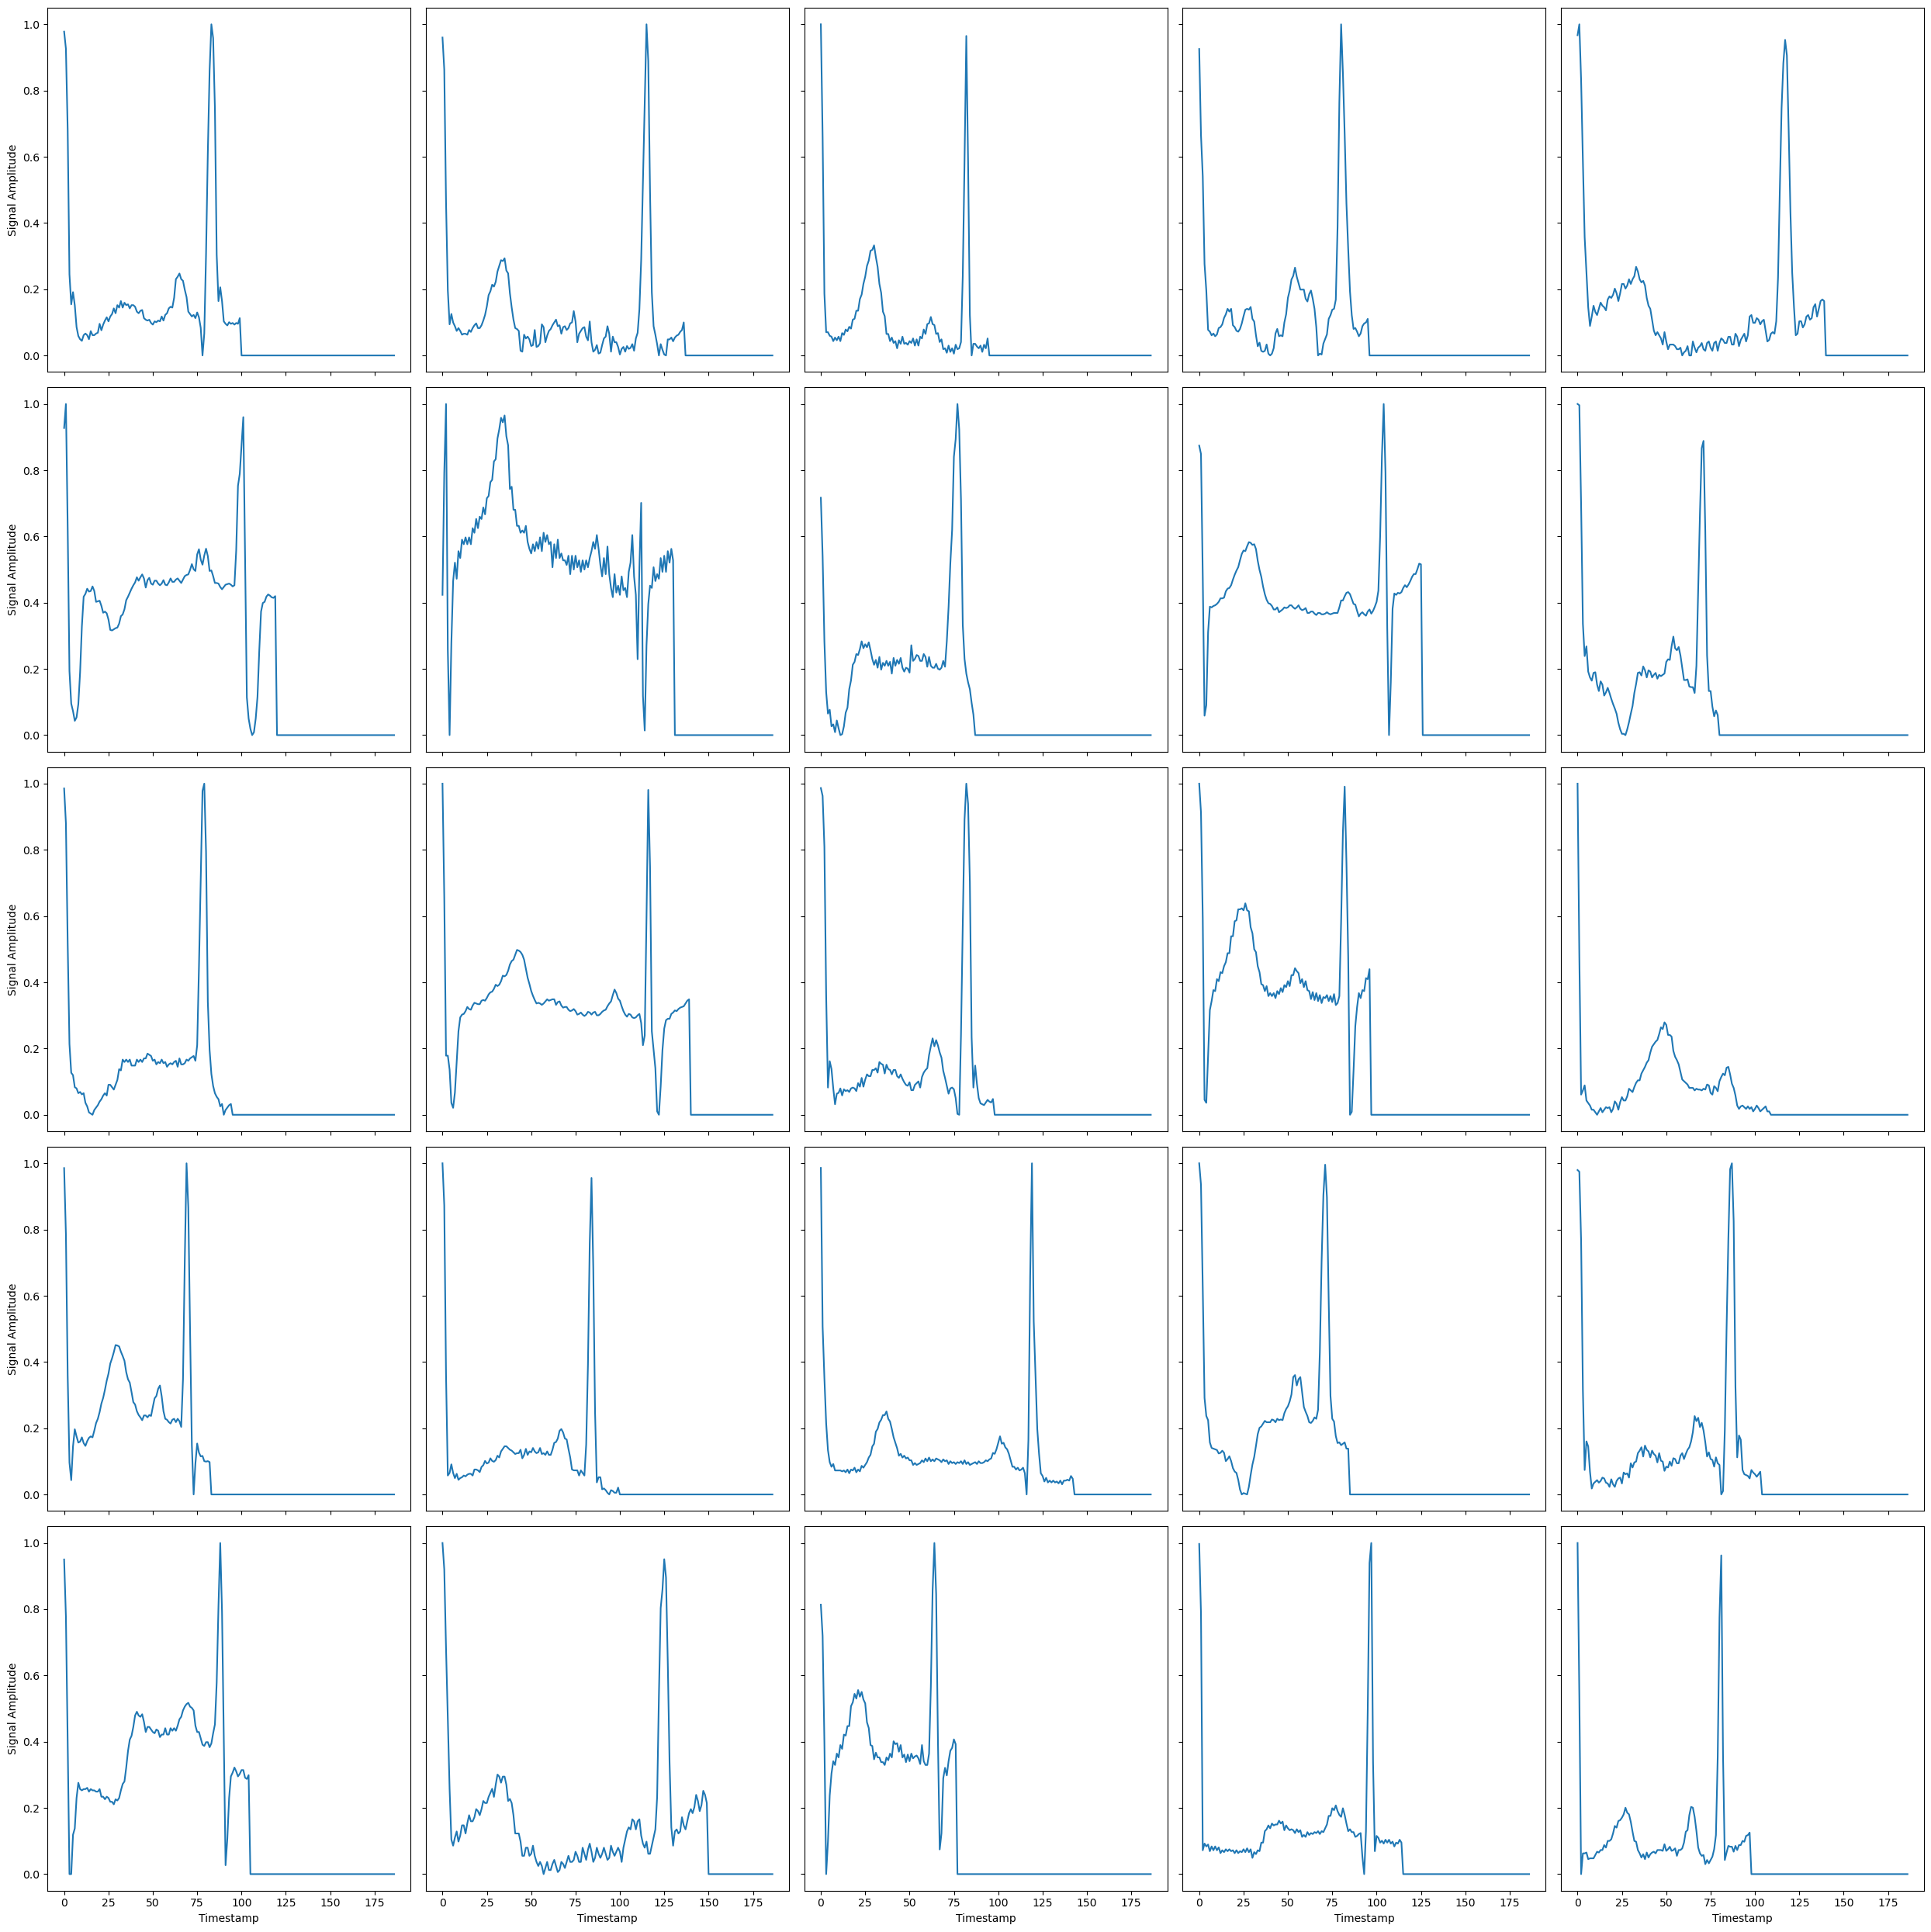

In [294]:
# visalize signal
def plot_signal(signal: np.ndarray) -> None:
    t = np.arange(signal.shape[-1])
    plt.plot(t, signal)

def plot_signals(signal: np.ndarray, n_rows: int = 5, n_cols: int = 5) -> None:
    if signal.ndim == 1:
        return plot_signal(signal)
    signal = np.asarray(signal).reshape(-1, signal.shape[-1])
    signal = signal[:n_rows * n_cols]
    r, c = math.ceil(signal.shape[0] / n_cols), min(n_cols, signal.shape[0])
    plt.subplots(r, c, figsize=(c * 5, r * 5), layout='tight', sharex=True, sharey=True)
    for i in range(signal.shape[0]):
        plt.subplot(r, c, i + 1)
        plot_signal(signal[i])
        if i % c == 0:
            plt.ylabel("Signal Amplitude")
        if i // c == r - 1:
            plt.xlabel("Timestamp")

plot_signals(train_X)
plt.show()

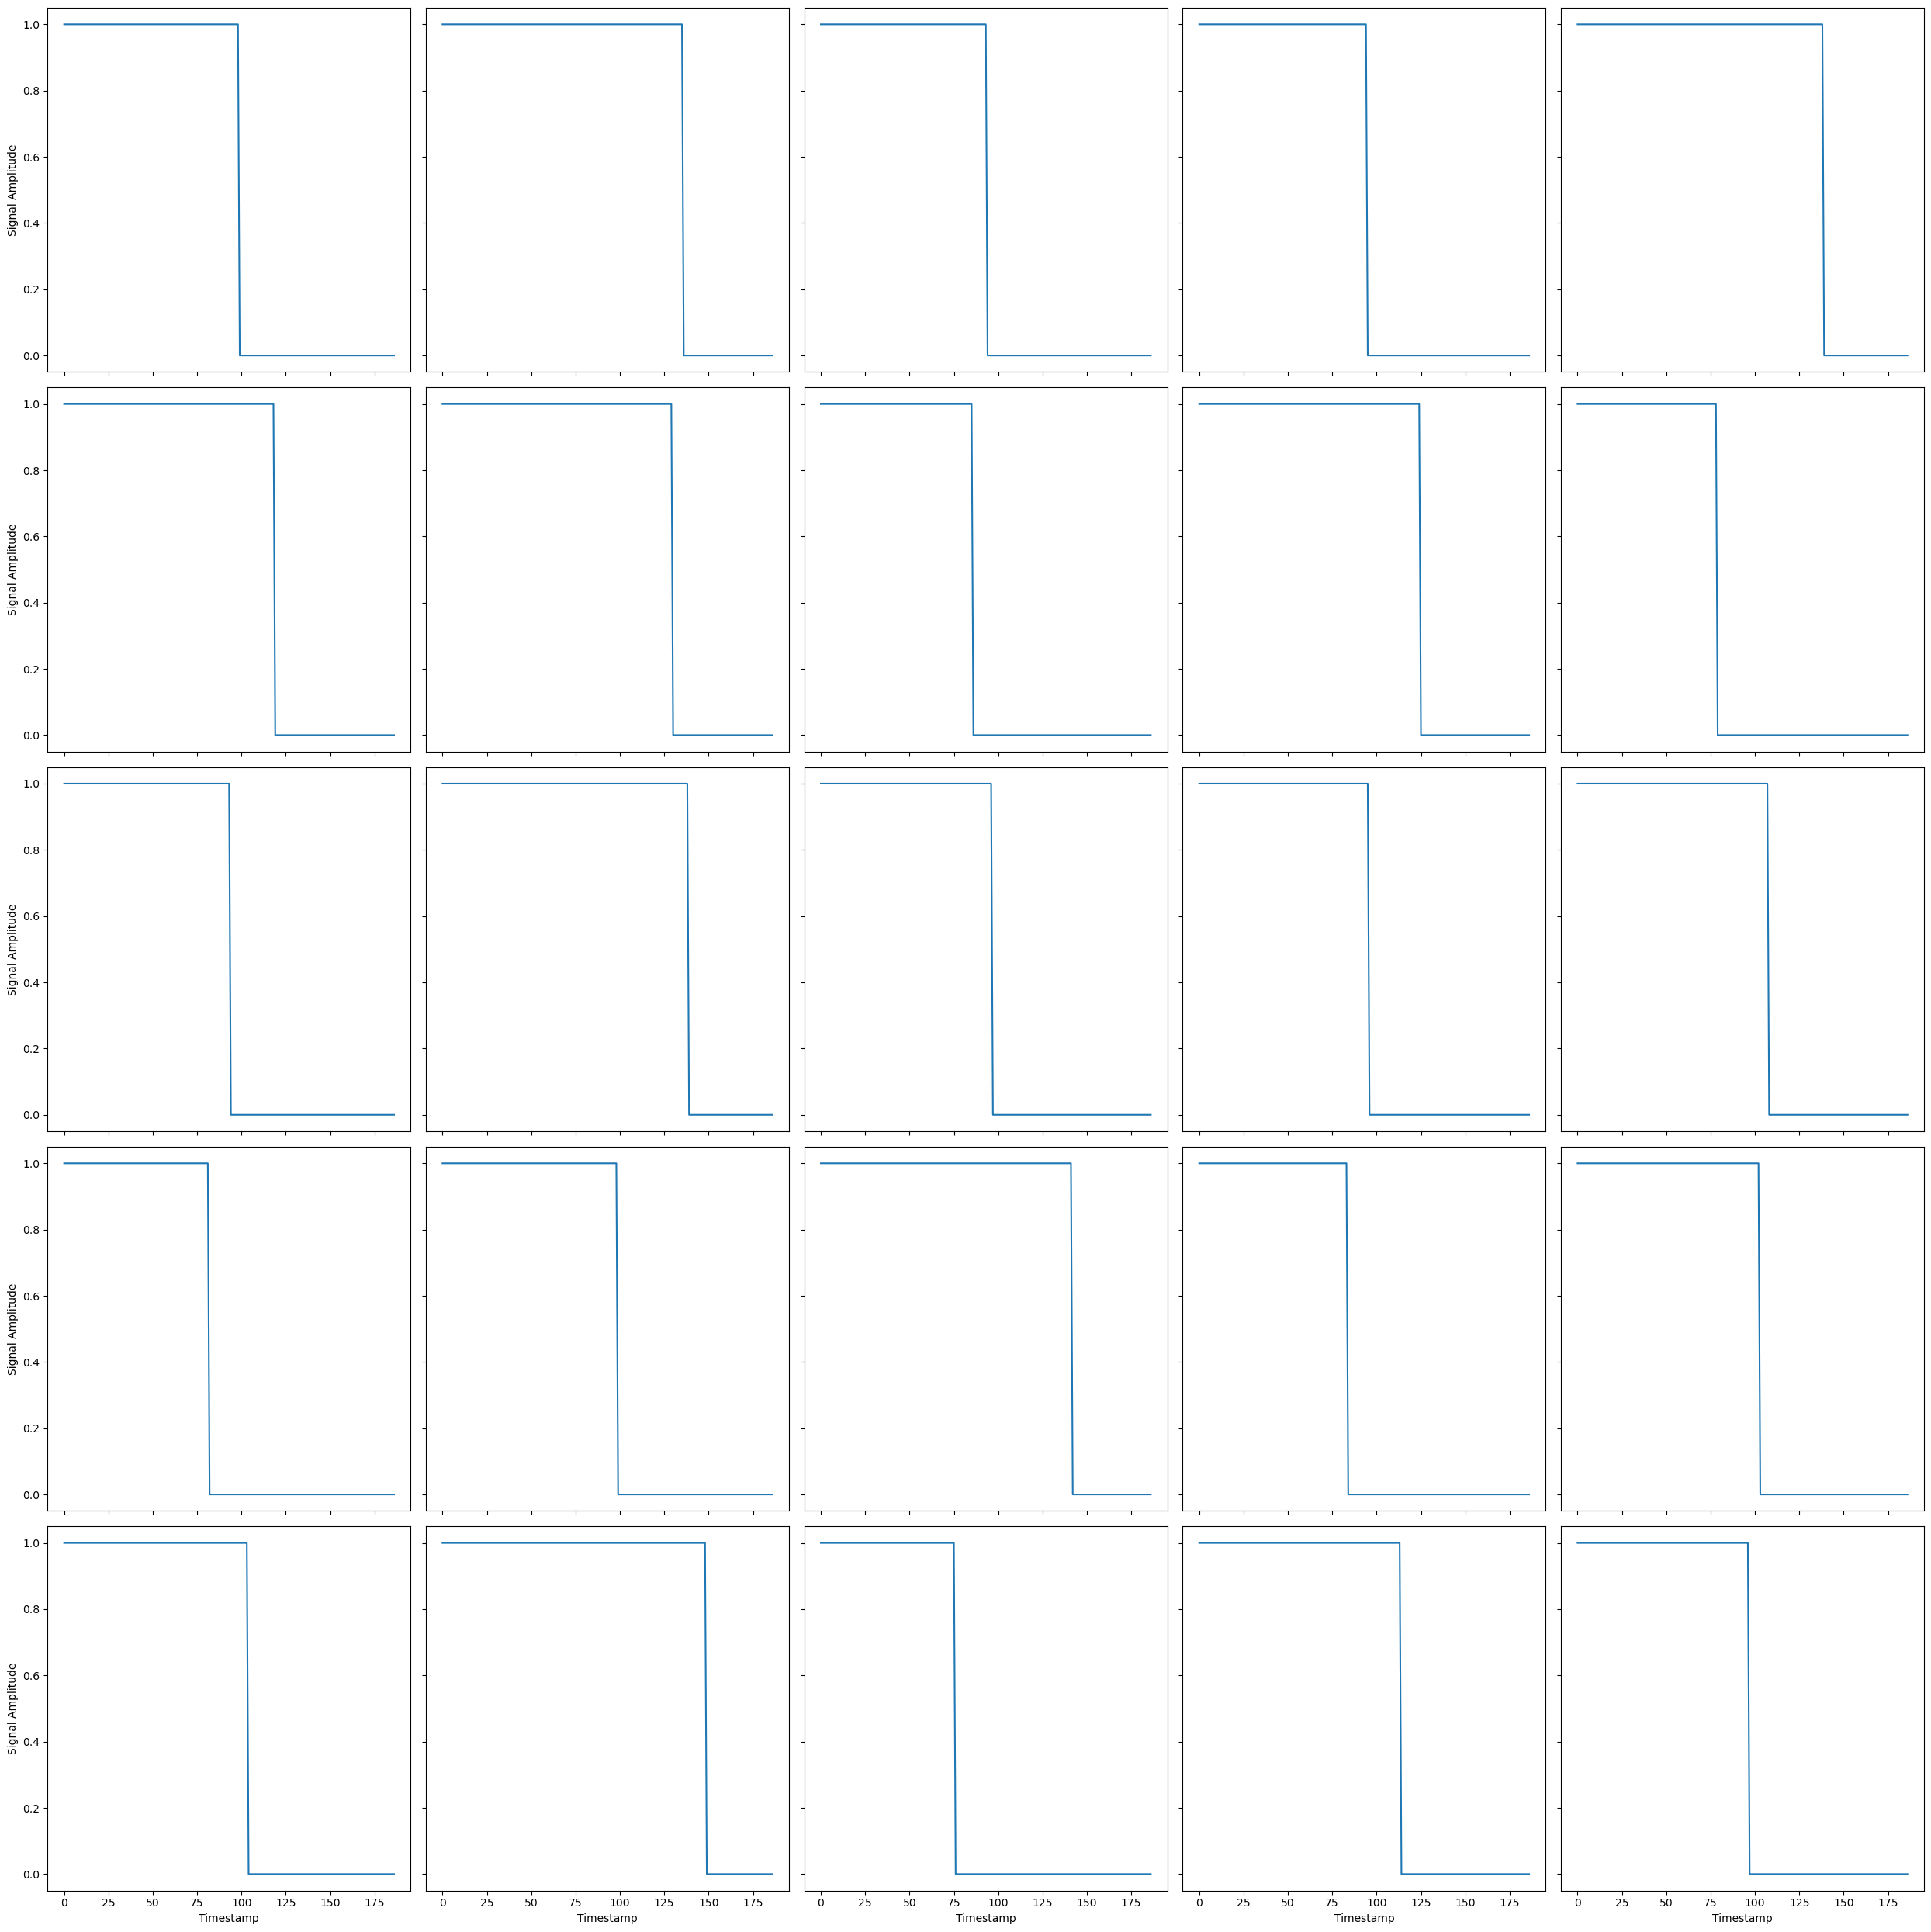

In [295]:
# generate masks for each signal
def generate_mask(signal: np.ndarray) -> np.ndarray:
    end = np.argmax((signal != 0).astype(float).cumsum(axis=1), axis=1)
    mask = np.ones_like(signal)
    for i, t in enumerate(end):
        mask[i, t:] = 0
    return mask

train_mask = generate_mask(train_X)
test_mask = generate_mask(test_X)
plot_signals(train_mask)
plt.show()

In [298]:
# perform train-test split
# may change to cross validation depending on training times
train_X, val_X, train_mask, val_mask, train_y, val_y = train_test_split(train_X, train_mask, train_y, test_size=0.2, random_state=42, stratify=train_y)
train_X = train_X.to_numpy()
val_X = val_X.to_numpy()
test_X = test_X.to_numpy()

In [570]:
# create datasets
def make_dataloader(X: np.ndarray, mask: np.ndarray, y: np.ndarray, batch_size: int=1, shuffle: bool=False) -> DataLoader:
    if shuffle:
        counts = 1 / pd.DataFrame(y).value_counts()
        counts.index = counts.index.get_level_values(0)
        counts = counts.to_dict(dict)
        weights = pd.Series(y).map(counts)
        weights = weights.to_numpy()
        sampler = torch.utils.data.WeightedRandomSampler(torch.tensor(weights).float(), len(y), replacement=True)
    X = torch.from_numpy(X).float()[:, :, None]
    mask = torch.from_numpy(mask).float()[:, :, None]
    y = torch.from_numpy(y).type(torch.long)[:]
    dataset = TensorDataset(X, mask, y)
    if shuffle:
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return DataLoader(dataset, batch_size=batch_size)

train_dataloader = make_dataloader(train_X, train_mask, train_y, batch_size=8, shuffle=True)
val_dataloader = make_dataloader(val_X, val_mask, val_y, batch_size=8, shuffle=False)
test_dataloader = make_dataloader(test_X, test_mask, test_y, batch_size=8, shuffle=False)

In [724]:
class_weight = 1 / pd.DataFrame(train_y).value_counts()
class_weight.index = class_weight.index.get_level_values(0)
class_weight = class_weight.sort_index()
class_weight = torch.tensor(class_weight.to_numpy()).float()

In [598]:
class AdditiveNoise(torch.nn.Module):
    def __init__(self, noise_level: float):
        super().__init__()
        self.noise_level = noise_level

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = x + torch.randn_like(x) * self.noise_level
        x[mask == 0] = 0
        x = torch.clamp(x, min=0, max=1)
        return x

class MultiplicativeNoise(torch.nn.Module):
    def __init__(self, corruption_level: float):
        super().__init__()
        self.corruption_level = corruption_level

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        return x * torch.bernoulli(torch.ones_like(x) * (1-self.corruption_level))

class CutMix:
    def __init__(self, mix: float, num_classes: int):
        self.mix_proportion = mix
        self.num_classes = num_classes
    
    def get_params(self, inpt: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        lengths = mask.sum(dim=-2)
        
        t = torch.rand(inpt.shape[0]) * lengths[:, 0]
        # self.mix_proportion * lengths[:, 0] is the max length that can be copied
        dt = torch.rand(inpt.shape[0]) * self.mix_proportion * lengths[:, 0]
        t1 = torch.clamp(t - dt / 2, min=0)
        t2 = torch.clamp(t + dt / 2, max=lengths[:,0])
        
        output = torch.logical_and(
            t1[:, None, None] <= torch.broadcast_to(torch.arange(inpt.shape[-2])[None, :, None], inpt.shape),
            torch.broadcast_to(torch.arange(inpt.shape[-2])[None, :, None], inpt.shape) <= t2[:, None, None]
        )
        mix = (output.type(torch.float32).sum(dim=[1,2])) / lengths[:, 0]
        return output, mix

    def transform(self, inpt: torch.Tensor, mask: torch.Tensor, cls: torch.Tensor) -> tuple[torch.Tensor]:
        t, alpha = self.get_params(inpt, mask)
        
        rolled = inpt.roll(shifts=1, dims=0) # mix with the next tensor
        output = inpt.clone()
        rolled_mask = mask.roll(shifts=1, dims=0)
        output_mask = mask.clone()
        
        output[t] = rolled[t]
        output_mask[t] = rolled_mask[t]
        
        output_cls = torch.nn.functional.one_hot(cls, num_classes=self.num_classes)
        output_cls = (1-alpha[:, None]) * output_cls + alpha[:, None] * output_cls.roll(shifts=1, dims=0)
        return output, output_mask, output_cls

In [305]:
class EarlyStopping:
    def __init__(self, patience: int, min_delta: float = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.lowest_loss = float('inf')

    def __call__(self, loss: float) -> bool:
        if loss < self.lowest_loss:
            self.lowest_loss = loss
            self.counter = 0
        elif loss > self.lowest_loss + self.min_delta:
            self.counter += 1
        return self.counter >= self.patience

class Checkpointer:
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.lowest_loss = float('inf')

    def __call__(self, model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float) -> None:
        if loss < self.lowest_loss:
            self.lowest_loss = loss
            state = {
                "epoch": epoch,
                "loss": loss,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(state, self.file_path)

    def load_best(self, model: torch.nn.Module, optimizer: torch.optim.Optimizer | None = None) -> torch.nn.Module:
        assert os.path.exists(self.file_path), "No checkpoint"
        state = torch.load(self.file_path, weights_only=True)
        model.load_state_dict(state['model'])
        if optimizer is not None:
            optimizer.load_state_dict(state['optimizer'])
            return model, optimizer
        return model

In [584]:
def train_loop(
    train_dataloader: DataLoader, 
    data_augmentation: torch.nn.Module,
    model: torch.nn.Module, 
    loss_fn: torch.nn.Module, 
    optimizer: torch.optim.Optimizer,
    device: str
) -> tuple[float, float]:
    n_samples = len(train_dataloader.dataset)
    loss = correct = 0
    model.train()
    for X, mask, y in train_dataloader:
        # move data to same device as model
        X = X.to(device)
        mask = mask.to(device)
        y = y.to(device)
        
        if data_augmentation is not None:
            for layer in data_augmentation:
                X = layer(X, mask)

        # forward pass
        pred = model(X, mask)
        batch_loss = loss_fn(pred, y)
        loss += batch_loss.cpu().detach().item() * len(X)
        classes = torch.nn.functional.softmax(pred, dim=-1).argmax(dim=-1)
        correct += torch.sum((classes == y).type(torch.float32)).cpu().detach().item()
        
        # backward pass
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    # calculate metrics
    correct /= n_samples
    loss /= n_samples
    return loss, correct

def test_loop(
    test_dataloader: DataLoader, 
    model: torch.nn.Module, 
    loss_fn: torch.nn.Module, 
    device: str
) -> tuple[float, float]:
    n_samples = len(test_dataloader.dataset)
    loss = correct = 0
    model.eval()
    with torch.inference_mode():
        for X, mask, y in test_dataloader:
            # move data to same device as model
            X = X.to(device)
            mask = mask.to(device)
            y = y.to(device)
    
            # forward pass
            pred = model(X, mask)
            batch_loss = loss_fn(pred, y)
            loss += batch_loss.cpu().detach().item() * len(X)
            classes = torch.nn.functional.softmax(pred, dim=-1).argmax(dim=-1)
            correct += torch.sum((classes == y).type(torch.float32)).cpu().detach().item()
            
    # calculate metrics
    correct /= n_samples
    loss /= n_samples
    return loss, correct

def train(
    train_dataloader: DataLoader, 
    validation_dataloader: DataLoader, 
    model: torch.nn.Module, 
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    max_epochs: int,
    early_stopper: EarlyStopping | None = None,
    checkpointer: Checkpointer | None = None,
    learning_rate_scheduler: torch.optim.lr_scheduler.LRScheduler | None = None,
    data_augmentation: torch.nn.ModuleList | None = None,
    device: str = 'cpu'
) -> tuple[list[float]]:
    
    training_loss_history = []
    training_accuracy_history = []
    validation_loss_history = []
    validation_accuracy_history = []
    model = model.to(device)
    if data_augmentation is not None:
        data_augmentation = data_augmentation.to(device)
        
    for epoch in range(max_epochs):
        train_loss, train_accuracy = train_loop(train_dataloader, data_augmentation, model, loss_fn, optimizer, device)
        training_loss_history.append(train_loss)
        training_accuracy_history.append(train_accuracy)

        validation_loss, validation_accuracy = test_loop(validation_dataloader, model, loss_fn, device)
        validation_loss_history.append(validation_loss)
        validation_accuracy_history.append(validation_accuracy)
        
        if learning_rate_scheduler is not None:
            learning_rate_scheduler.step()
        if checkpointer is not None and checkpointer(model, optimizer, epoch, validation_loss):
            pass
        print(f"Epoch {epoch + 1}/{max_epochs}: Training Loss: {train_loss:>.8f} | Training Accuracy: {train_accuracy*100:>.2f}% | Validation Loss: {validation_loss:>.8f} | Validation Accuracy: {validation_accuracy*100:>.2f}%")
        if early_stopper is not None and early_stopper(validation_loss):
            print("Complete")
            break
    
    if checkpointer is not None:
        model, optimizer = checkpointer.load_best(model, optimizer)
    return training_loss_history, training_accuracy_history, validation_loss_history, validation_accuracy_history

In [448]:
class RNNModel(torch.nn.Module):
    def __init__(self, num_features: int, rnn_num_hidden: int, mlp_nodes: int, num_layers: int = 1, RNN_dropout: float = 0, bidirectional: bool = False):
        super().__init__()
        
        self.initial_mlp = torch.nn.Sequential(
            torch.nn.Linear(num_features, rnn_num_hidden),
            torch.nn.ReLU()
        )
        
        self.rnn = torch.nn.LSTM(rnn_num_hidden, rnn_num_hidden, batch_first=True, num_layers=num_layers, dropout=RNN_dropout, bidirectional=bidirectional)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(rnn_num_hidden * (2 if bidirectional else 1), mlp_nodes[0]),
            *[torch.nn.Sequential(
                torch.nn.LayerNorm(mlp_nodes[i]),
                torch.nn.ReLU(),
                torch.nn.Linear(mlp_nodes[i], mlp_nodes[i+1])
            ) for i in range(len(mlp_nodes) - 1)],
        )
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = self.initial_mlp(x)
        x, _ = self.rnn(x)
        x = x.sum(dim=1) / mask.sum(dim=1)
        return self.mlp(x)

In [450]:
model = RNNModel(1, 16, [16, 8, 5])
model

RNNModel(
  (initial_mlp): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
  )
  (rnn): LSTM(16, 16, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Sequential(
      (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
    )
    (2): Sequential(
      (0): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=5, bias=True)
    )
  )
)

In [580]:
model = RNNModel(1, 16, [16, 8, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loss, train_acc, val_loss, val_acc = train(train_dataloader, val_dataloader, model, torch.nn.CrossEntropyLoss(), optimizer, 10, device='cuda', early_stopper=EarlyStopping(10))

Epoch 1/10: Training Loss: 1.01804491 | Training Accuracy: 61.09% | Validation Loss: 1.36718318 | Validation Accuracy: 35.46%
Epoch 2/10: Training Loss: 0.80848322 | Training Accuracy: 70.81% | Validation Loss: 0.91663847 | Validation Accuracy: 60.41%
Epoch 3/10: Training Loss: 0.59126829 | Training Accuracy: 78.76% | Validation Loss: 0.89483929 | Validation Accuracy: 61.26%
Epoch 4/10: Training Loss: 0.50036498 | Training Accuracy: 82.37% | Validation Loss: 0.55591818 | Validation Accuracy: 80.44%
Epoch 5/10: Training Loss: 0.44613574 | Training Accuracy: 84.44% | Validation Loss: 0.53598901 | Validation Accuracy: 81.79%
Epoch 6/10: Training Loss: 0.40229047 | Training Accuracy: 86.12% | Validation Loss: 0.47422517 | Validation Accuracy: 84.94%
Epoch 7/10: Training Loss: 0.37297777 | Training Accuracy: 87.12% | Validation Loss: 0.57667225 | Validation Accuracy: 80.18%
Epoch 8/10: Training Loss: 0.34528482 | Training Accuracy: 88.08% | Validation Loss: 0.46710677 | Validation Accuracy:

In [600]:
data_augmentation = torch.nn.ModuleList([
    AdditiveNoise(1e-2),
    MultiplicativeNoise(0.1)
])
model = RNNModel(1, 16, [16, 8, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loss, train_acc, val_loss, val_acc = train(train_dataloader, val_dataloader, model, torch.nn.CrossEntropyLoss(), optimizer, 10, device='cuda', early_stopper=EarlyStopping(10), data_augmentation=data_augmentation)

Epoch 1/10: Training Loss: 1.09716327 | Training Accuracy: 56.30% | Validation Loss: 1.29457353 | Validation Accuracy: 45.78%
Epoch 2/10: Training Loss: 0.96095410 | Training Accuracy: 64.09% | Validation Loss: 1.40600358 | Validation Accuracy: 39.11%
Epoch 3/10: Training Loss: 0.86253474 | Training Accuracy: 68.69% | Validation Loss: 1.25768299 | Validation Accuracy: 46.31%
Epoch 4/10: Training Loss: 0.73196990 | Training Accuracy: 73.76% | Validation Loss: 0.93705240 | Validation Accuracy: 62.69%
Epoch 5/10: Training Loss: 0.58588070 | Training Accuracy: 79.03% | Validation Loss: 0.70693276 | Validation Accuracy: 77.33%
Epoch 6/10: Training Loss: 0.50214919 | Training Accuracy: 81.76% | Validation Loss: 0.63878473 | Validation Accuracy: 80.68%
Epoch 7/10: Training Loss: 0.52786664 | Training Accuracy: 80.92% | Validation Loss: 0.74788712 | Validation Accuracy: 73.92%
Epoch 8/10: Training Loss: 0.45703532 | Training Accuracy: 83.75% | Validation Loss: 0.92357269 | Validation Accuracy:

In [644]:
class CNNModel(torch.nn.Module):
    def __init__(self, num_features: int, cnn_nodes: list[int], mlp_nodes: list[int]):
        super().__init__()
        
        cnn_nodes = [num_features] + cnn_nodes
        self.cnn = torch.nn.Sequential(
            *[torch.nn.Sequential(
                torch.nn.Conv1d(cnn_nodes[i], cnn_nodes[i+1], 3, padding='same'),
                torch.nn.BatchNorm1d(cnn_nodes[i+1]),
                torch.nn.ReLU(),
                torch.nn.AvgPool1d(3)
            ) for i in range(len(cnn_nodes) - 1)],
            torch.nn.Flatten()
        )
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(cnn_nodes[-1] * (187 // 3**(len(cnn_nodes) - 1)), mlp_nodes[0]),
            *[torch.nn.Sequential(
                torch.nn.LayerNorm(mlp_nodes[i]),
                torch.nn.ReLU(),
                torch.nn.Linear(mlp_nodes[i], mlp_nodes[i+1])
            ) for i in range(len(mlp_nodes) - 1)],
        )
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = torch.transpose(x, -1, -2)
        x = self.cnn(x)
        return self.mlp(x)

In [730]:
model = CNNModel(1, [16, 32, 64], [64, 16, 5])
model

CNNModel(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (1): Sequential(
      (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=64, bias=True)
    (1): Sequential(
  

In [646]:
model = CNNModel(1, [16, 32, 64], [64, 16, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loss, train_acc, val_loss, val_acc = train(train_dataloader, val_dataloader, model, torch.nn.CrossEntropyLoss(class_weight), optimizer, 10, device='cuda', early_stopper=EarlyStopping(10), data_augmentation=data_augmentation)

Epoch 1/10: Training Loss: 0.38490984 | Training Accuracy: 86.33% | Validation Loss: 0.32720254 | Validation Accuracy: 88.48%
Epoch 2/10: Training Loss: 0.20860955 | Training Accuracy: 92.49% | Validation Loss: 0.32226411 | Validation Accuracy: 88.80%
Epoch 3/10: Training Loss: 0.16292890 | Training Accuracy: 94.13% | Validation Loss: 0.13664579 | Validation Accuracy: 95.52%
Epoch 4/10: Training Loss: 0.13085644 | Training Accuracy: 95.33% | Validation Loss: 0.15470859 | Validation Accuracy: 94.41%
Epoch 5/10: Training Loss: 0.11564343 | Training Accuracy: 95.84% | Validation Loss: 0.18113134 | Validation Accuracy: 93.80%
Epoch 6/10: Training Loss: 0.10438122 | Training Accuracy: 96.33% | Validation Loss: 0.13991594 | Validation Accuracy: 95.06%
Epoch 7/10: Training Loss: 0.09441133 | Training Accuracy: 96.65% | Validation Loss: 0.11042397 | Validation Accuracy: 96.30%
Epoch 8/10: Training Loss: 0.08706173 | Training Accuracy: 96.94% | Validation Loss: 0.13409610 | Validation Accuracy:

In [648]:
data_augmentation = torch.nn.ModuleList([
    AdditiveNoise(1e-2),
    MultiplicativeNoise(0.1)
])
model = CNNModel(1, [16, 32, 64], [64, 16, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loss, train_acc, val_loss, val_acc = train(train_dataloader, val_dataloader, model, torch.nn.CrossEntropyLoss(class_weight), optimizer, 10, device='cuda', early_stopper=EarlyStopping(10), data_augmentation=data_augmentation)

Epoch 1/10: Training Loss: 0.39150660 | Training Accuracy: 85.99% | Validation Loss: 0.33605359 | Validation Accuracy: 88.36%
Epoch 2/10: Training Loss: 0.20891239 | Training Accuracy: 92.43% | Validation Loss: 0.27232315 | Validation Accuracy: 89.51%
Epoch 3/10: Training Loss: 0.15565733 | Training Accuracy: 94.46% | Validation Loss: 0.18894069 | Validation Accuracy: 93.36%
Epoch 4/10: Training Loss: 0.13362301 | Training Accuracy: 95.22% | Validation Loss: 0.24243913 | Validation Accuracy: 90.49%
Epoch 5/10: Training Loss: 0.11621998 | Training Accuracy: 95.84% | Validation Loss: 0.18568138 | Validation Accuracy: 93.72%
Epoch 6/10: Training Loss: 0.10532129 | Training Accuracy: 96.33% | Validation Loss: 0.13922423 | Validation Accuracy: 94.99%
Epoch 7/10: Training Loss: 0.09314390 | Training Accuracy: 96.67% | Validation Loss: 0.14279218 | Validation Accuracy: 95.23%
Epoch 8/10: Training Loss: 0.08775924 | Training Accuracy: 96.96% | Validation Loss: 0.18735918 | Validation Accuracy:

In [684]:
class CNNRNNModel(torch.nn.Module):
    def __init__(self, num_features: int, cnn_nodes: list[int], rnn_num_hidden: int, mlp_nodes: list[int], num_layers: int = 1, RNN_dropout: float = 0, bidirectional: bool = False):
        super().__init__()
        
        cnn_nodes = [num_features] + cnn_nodes
        self.cnn = torch.nn.Sequential(
            *[torch.nn.Sequential(
                torch.nn.Conv1d(cnn_nodes[i], cnn_nodes[i+1], 3, padding='same'),
                torch.nn.BatchNorm1d(cnn_nodes[i+1]),
                torch.nn.ReLU(),
                torch.nn.AvgPool1d(3)
            ) for i in range(len(cnn_nodes) - 1)]
        )
        
        self.rnn = torch.nn.LSTM(cnn_nodes[-1], rnn_num_hidden, batch_first=True, num_layers=num_layers, dropout=RNN_dropout, bidirectional=bidirectional)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(rnn_num_hidden * (2 if bidirectional else 1), mlp_nodes[0]),
            *[torch.nn.Sequential(
                torch.nn.LayerNorm(mlp_nodes[i]),
                torch.nn.ReLU(),
                torch.nn.Linear(mlp_nodes[i], mlp_nodes[i+1])
            ) for i in range(len(mlp_nodes) - 1)],
        )
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = torch.transpose(x, -1, -2)
        x = self.cnn(x)
        x = torch.transpose(x, -1, -2)
        x, _ = self.rnn(x)
        x = x.sum(dim=1) / mask.sum(dim=1)
        return self.mlp(x)

In [732]:
model = CNNRNNModel(1, [16, 32, 64], 64, [64, 16, 5])
model

CNNRNNModel(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (1): Sequential(
      (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
  )
  (rnn): LSTM(64, 64, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sequential(
  

In [690]:
model = CNNRNNModel(1, [16, 32, 64], 64, [64, 16, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loss, train_acc, val_loss, val_acc = train(train_dataloader, val_dataloader, model, torch.nn.CrossEntropyLoss(class_weight), optimizer, 10, device='cuda', early_stopper=EarlyStopping(10), data_augmentation=data_augmentation)

Epoch 1/10: Training Loss: 0.53161551 | Training Accuracy: 80.68% | Validation Loss: 0.35309918 | Validation Accuracy: 89.93%
Epoch 2/10: Training Loss: 0.27969582 | Training Accuracy: 90.13% | Validation Loss: 0.38621675 | Validation Accuracy: 86.37%
Epoch 3/10: Training Loss: 0.20164603 | Training Accuracy: 92.78% | Validation Loss: 0.32922004 | Validation Accuracy: 88.29%
Epoch 4/10: Training Loss: 0.17026717 | Training Accuracy: 94.02% | Validation Loss: 0.25364162 | Validation Accuracy: 90.74%
Epoch 5/10: Training Loss: 0.14464388 | Training Accuracy: 94.85% | Validation Loss: 0.22228393 | Validation Accuracy: 91.99%
Epoch 6/10: Training Loss: 0.13308153 | Training Accuracy: 95.31% | Validation Loss: 0.15210633 | Validation Accuracy: 94.57%
Epoch 7/10: Training Loss: 0.11953161 | Training Accuracy: 95.69% | Validation Loss: 0.15873997 | Validation Accuracy: 94.14%
Epoch 8/10: Training Loss: 0.11138009 | Training Accuracy: 96.09% | Validation Loss: 0.17353160 | Validation Accuracy:

In [692]:
data_augmentation = torch.nn.ModuleList([
    AdditiveNoise(1e-2),
    MultiplicativeNoise(0.1)
])
model = CNNRNNModel(1, [16, 32, 64], 64, [64, 16, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loss, train_acc, val_loss, val_acc = train(train_dataloader, val_dataloader, model, torch.nn.CrossEntropyLoss(class_weight), optimizer, 10, device='cuda', early_stopper=EarlyStopping(10), data_augmentation=data_augmentation)

Epoch 1/10: Training Loss: 0.49935368 | Training Accuracy: 81.76% | Validation Loss: 0.41014722 | Validation Accuracy: 87.37%
Epoch 2/10: Training Loss: 0.26805249 | Training Accuracy: 90.25% | Validation Loss: 0.45072580 | Validation Accuracy: 81.19%
Epoch 3/10: Training Loss: 0.19884844 | Training Accuracy: 92.78% | Validation Loss: 0.37166790 | Validation Accuracy: 84.38%
Epoch 4/10: Training Loss: 0.16408123 | Training Accuracy: 94.07% | Validation Loss: 0.22070364 | Validation Accuracy: 91.65%
Epoch 5/10: Training Loss: 0.13735073 | Training Accuracy: 95.10% | Validation Loss: 0.15490441 | Validation Accuracy: 94.75%
Epoch 6/10: Training Loss: 0.12556220 | Training Accuracy: 95.52% | Validation Loss: 0.23321205 | Validation Accuracy: 91.27%
Epoch 7/10: Training Loss: 0.11431903 | Training Accuracy: 95.97% | Validation Loss: 0.18940130 | Validation Accuracy: 92.94%
Epoch 8/10: Training Loss: 0.10339817 | Training Accuracy: 96.34% | Validation Loss: 0.14329401 | Validation Accuracy:

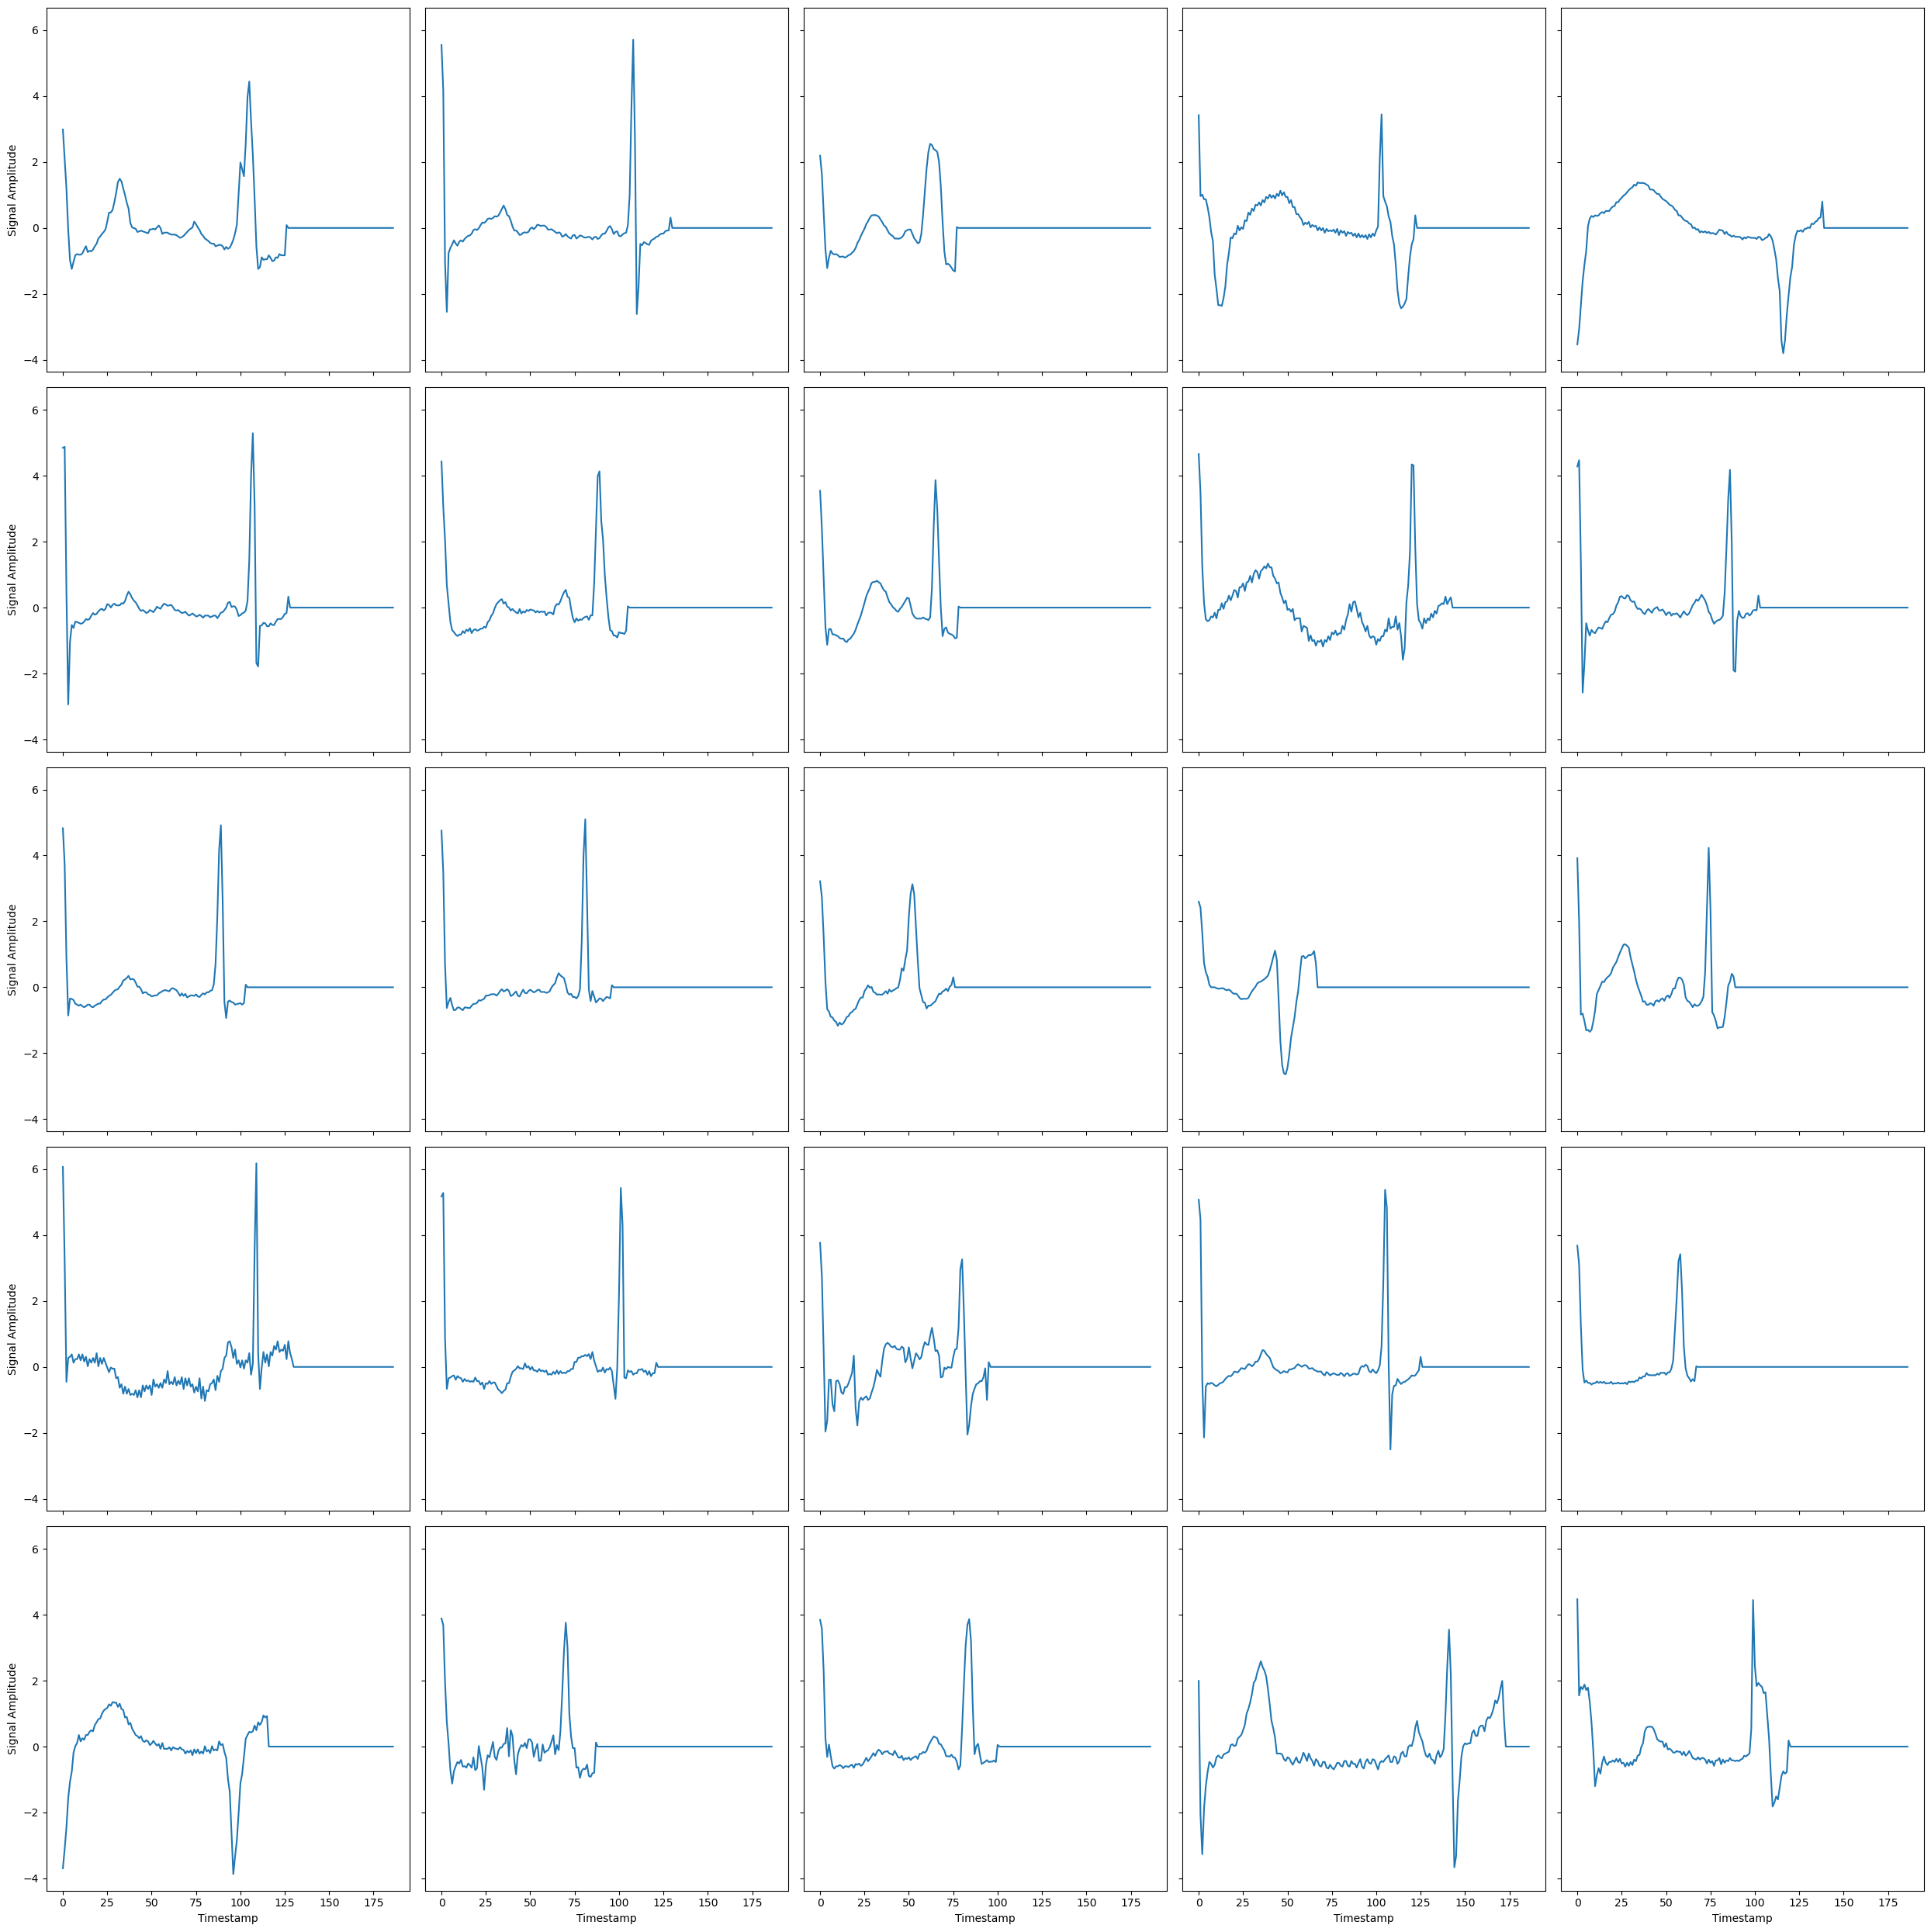

In [28]:
# perform normalization
def normalize(signal: np.ndarray, mask: np.ndarray, epsilon: float = 1e-7) -> np.ndarray:
    # compute using masked arrays due to mask
    # 1 in masked array indicates hide
    # but our mask indicates keep
    signal = np.ma.masked_array(signal, mask=1 - mask)
    signal = (signal - signal.mean(axis=1)[:, np.newaxis]) / ((signal.var(axis=1)[:, np.newaxis] + epsilon) ** 0.5)
    return signal.data

scaled_train_X = normalize(train_X, train_mask)
scaled_val_X = normalize(val_X, val_mask)
scaled_test_X = normalize(test_X, test_mask)
plot_signals(scaled_train_X)
plt.show()

In [ ]:
# check if cutmix implementation works
temp_dataloader = make_dataloader(scaled_train_X[np.arange(0, len(scaled_train_X), 1000)], train_mask[np.arange(0, len(scaled_train_X), 1000)], train_y[np.arange(0, len(scaled_train_X), 1000)], batch_size=9, shuffle=True)
x, m, y = next(temp_dataloader.__iter__())
cutmix = CutMix(0.3, 5)
x_t, m_t, y_t = cutmix.transform(x, m, y)

plt.subplots(3, 3, figsize=(15, 15), layout='tight')
t = np.arange(x.shape[1])
for i in range(8):
    plt.subplot(3, 3, i + 1)
    plt.plot(t, x[i, :, 0].numpy(), label='Original')
    plt.plot(t, x_t[i, :, 0].numpy(), label='Transformed')
    plt.text(100, 0.2, "Original: " + str(y[i].item()), horizontalalignment='center')
    plt.text(100, -0.2, "Transformed: " + str(list(y_t[i].numpy())), horizontalalignment='center')
    plt.legend()
plt.show()